In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## What is a slope?

In [3]:
def f(x): 
    return 3*x**2 -4*x + 5

In [4]:
f(3.0)

20.0

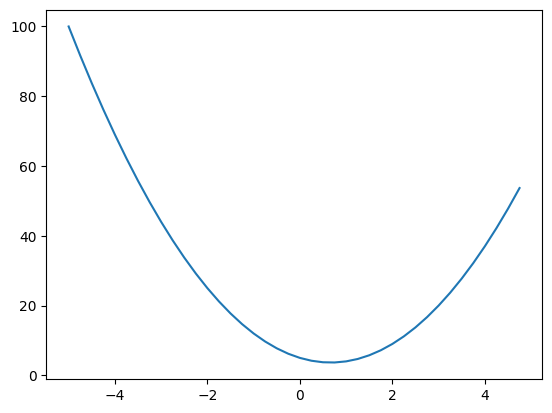

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = 3.0
# Estimating the derivative at x = 3
(f(x + h) - f(x)) / h

14.000000305713911

In [7]:
# Lets get more complex 
a = 2.0
b = -3.0
c = 10
d = a*b + c
print(d) 

4.0


In [8]:
h = 0.0001

# inputs 
a = 2.0
b = -3.0
c = 10.0

# How does d respond to a small change in a? 
d1 = a*b + c
c += h
d2 = a*b + c 

print('d1', d1)
print('d2', d2) 
print('slope:', (d2-d1)/h)

d1 4.0
d2 4.0001
slope: 0.9999999999976694


In [9]:
## Now moving to NN ##

In [197]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd' # this is equivalent to a.__mul__(b).__add__(c)
f = Value(-2.0, label='f')
L = d * f; L.label='L'
d

Value(data=4.0)

In [199]:
a = Value(2)
b = Value(4)
a * 2
2 * a
a / b
a - 2
2-a

TypeError: unsupported operand type(s) for -: 'int' and 'Value'

In [12]:
d._prev

{Value(data=-6.0), Value(data=10)}

In [13]:
d._op

'+'

L = d * f

dL/dd = f
dL/df = d

### CRUX OF BACKPROPOGATION
### How do we find: 
dL/dc?
Well, the chain rule. dL/dc = dL/dd * dd/dc. 

Intuition: rates of change... if dL/dd describes the rate of change of L wrt to d, and 
dd/dc is the rate of change of d wrt c, then we can multiply the rates of change together 
to get the total rate of change

We already calculated dL/dd. So we just need to calculate dd/dc. This is the heart of backprop.
Based on this. we should expect to see that dL/dd = dL/dc = -2. 
As we can see, a "plus node" simply propogates the gradient to the next node.

### Finally, we want to calculate a.grad, or dL/da. Or, put a different way, how a small 
change in a affects the outcome of L. Put in a final way, how does the rate of change in 
a affect the rate of change in L. 

ANSWER: dL/da = (dL/de)*(de/da)
dL/de = -2
de/da = b = -3.0 # NOTE that the local gradient around a mult node is the val of the other node
so dL/da = -2*-3 = 6

Similarly, 
dL/de = -2
dL/db = 2.0
so dL/db = 2*-2 = -4

In [14]:
def lol(): 

    h = 0.0001

    # Definition of values 
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    # Same definitions, but bump the values by some small amount to verify gradient
    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

lol()

-4.000000000008441


In [15]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2
c.grad = -2
e.grad = -2
a.grad = 6
b.grad = -4

In [16]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data: %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot


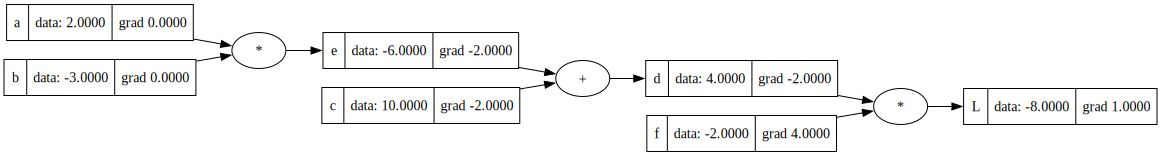

In [17]:
draw_dot(L)

In [18]:
## Chapter 3

In [19]:
# Now, lets make L go up by manually by modifying each intermediate value in the direction 
# of its partial derivative. This nudges the whole function in the direction of the gradient
### Note: Why does moving in the direction of the gradient the direction of max ascent? 
### Answer: consider the directional derivative, grad(f) • u, where u is a unit vector pointing
### in some direction. grad(f) is a vector of values of partial derivatives of f wrt to each
### direction (dimension). The magnitude of the directional derivative is maximized when 
### u is pointing in the same direction as grad(f) because of the def of dot product (cos(theta))

# There are four quantities (leaf nodes) that we can control: 
a.data += 0.001 * a.grad
b.data += 0.001 * b.grad
c.data += 0.001 * c.grad
f.data += 0.001 * f.grad
# By the way, this 0.001 is the "step size" 

# rewriting the forward pass!
e = a*b; e.label = 'e'
d = e + c; d.label = 'd' # this is equivalent to a.__mul__(b).__add__(c)
L = d * f; L.label='L'

print(L.data)

# We have now done a single optimization step. In other words, we have done one single "training"
# example. We backpropogated, changed the weights according to the gradient, and calculated the 
# next loss function

-35.955896096


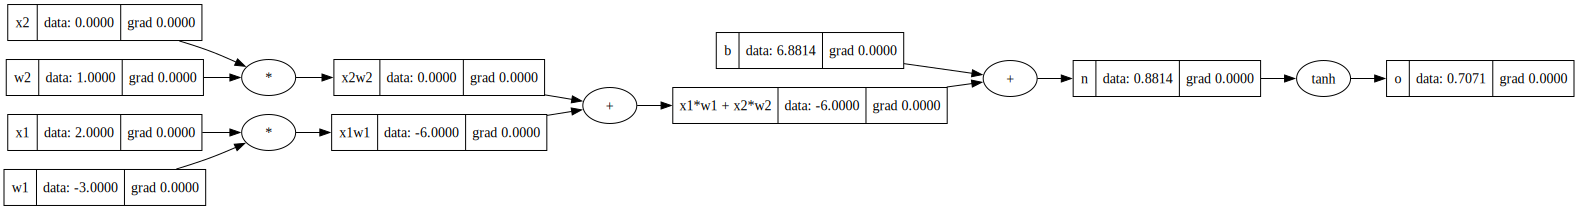

In [20]:
# Chapter 4: NN Backpropogation

# We want to define a net with two inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Define the weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias: the bias determine how "trigger happy" each neuron is. in other words its "synaptic strength"
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' # This is the nonlinearity function. We are going with tanh
draw_dot(o)

### Now, lets backpropogate through the single neuron network

### We start with the base case: how does o change with respect to o? do/do = 1 
do/do = 1
### What is do/dn? 
Well, o = tanh(n). So do/dn = 1 - tanh^2(n). Plugging in the value, we get: 
do/dn = 1-tanh^2(0.8814) = 0.5

### What is do/db and do/dx1w1...
### Well, in a "plus node", we know that the gradients are just passed through because a plus operation between two nodes will yield a gradient of 1, which is then multiplied by the gradient in the next node
dn/db = 1
do/db = do/dn * dn/db = 0.5

Same is true for x1w1x2w2. do/dx1w1x2w2 = 0.5


### Next, do/dx1w1 and do/dx2w2
do/dx1w1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1
do/dx1w1 = (0.5) * (1) * (1) = 0.5

Same for do/dx2w2

### Finally, the quantities we care about (and control), w1 and w2:
do/dw1 = do/dn * dn/x1w1x2w2 * dx1w1x2w2/dx1w1 * dx1w1/dw1
do/dw1 = (0.5) * (1) * (1) * (x1)
do/dw1 = 0.5 * (2.0) = 1.0

similarly, we can see do/dw2 = 0

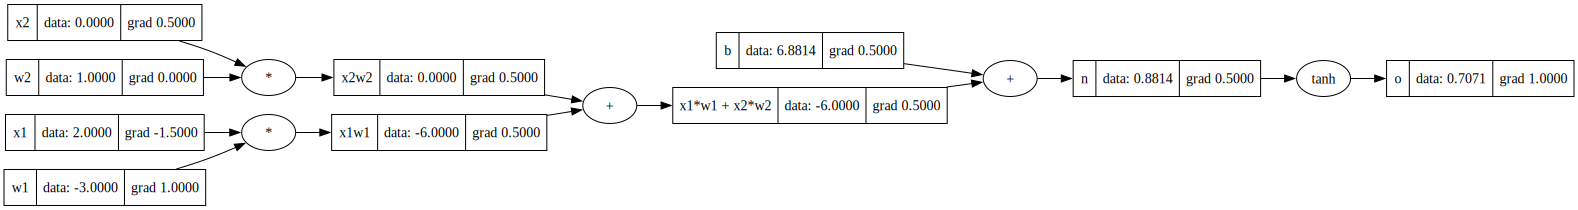

In [21]:
o.grad = 1
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
w1.grad = x1.data * x1w1.grad # This is the little "local piece of chain rule"
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad 
x2.grad = w2.data * x2w2.grad

draw_dot(o)

### Some notes

Notice that the gradient of w2 is 0 because x2.data is 0. This makes sense intuitively. The gradient tells us how we can wiggle the parameter and how it will change the final output. In this case, the final output will obviously be unchanged because the data is 0. 

## Chapter 5: Automating backprop with Value obj

In [22]:
# We define the same neuron with two inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Define the weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias: the bias determine how "trigger happy" each neuron is. in other words its "synaptic strength"
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o' # This is the nonlinearity function. We are going with tanh

In [23]:
# Calling ._backward in the right order, last to first 
o.grad = 1.0 # Set the base case, grad initialized = 0.0

In [24]:
o._backward()

In [25]:
n._backward()

In [26]:
b._backward()

In [27]:
x1w1x2w2._backward()

In [28]:
x1w1._backward()
x2w2._backward()

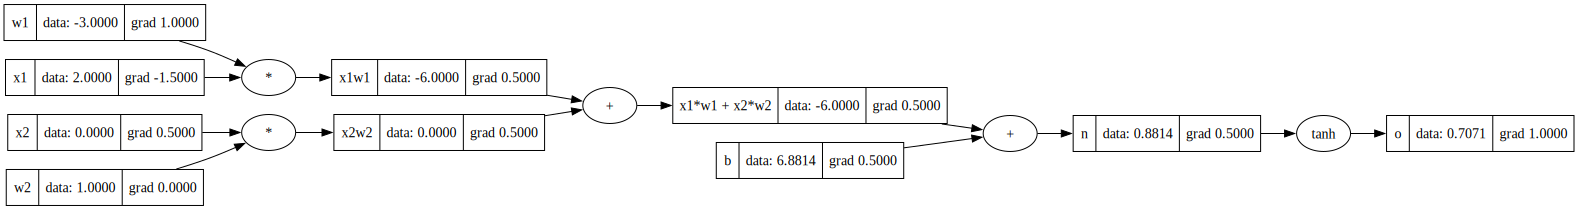

In [29]:
draw_dot(o)

### The final step is to automate ._backward calls
The way to achieve this is to iterate through all of the nodes. Can we do this in any order? No! The order matters. _backward must not be called on a node until all of the nodes it points to (its ancestors) have received the _backward call. This is because the local gradient depends on the gradients of the ancestors. This is not so clear in this example, but one can imagine a fully connected NN. You cannot call ._backward on a specific node until the gradients of all of the nodes it points to have been computed. 

How do we do this? Topological sort! Topological sort orders all of the nodes of a DAG such that all the for every directed edge (u,v), vertex u comes before vertex v in the ordering. 

In [30]:
o.backward()

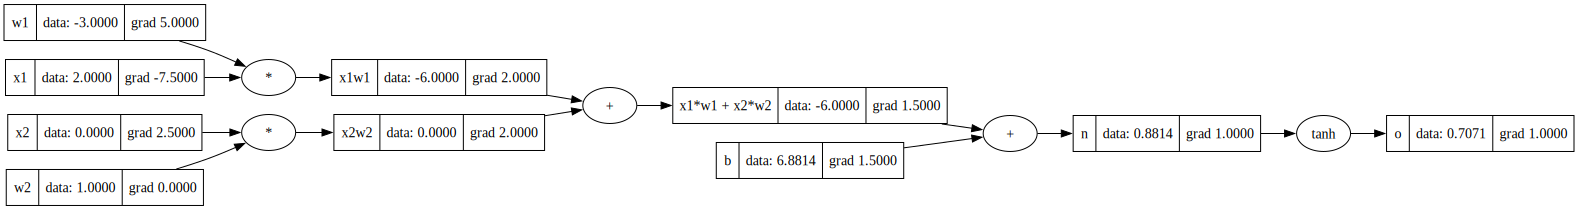

In [31]:
# Iterate through the list in reverse order and call backward on each node

draw_dot(o)

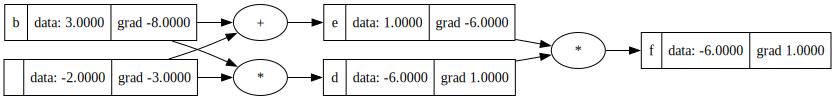

In [32]:
# Testing whether adding something twice works
a = Value(-2.0)
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e' 
f = d * e; f.label = 'f' 

f.backward()
draw_dot(f)

## Chapter 6: More operations

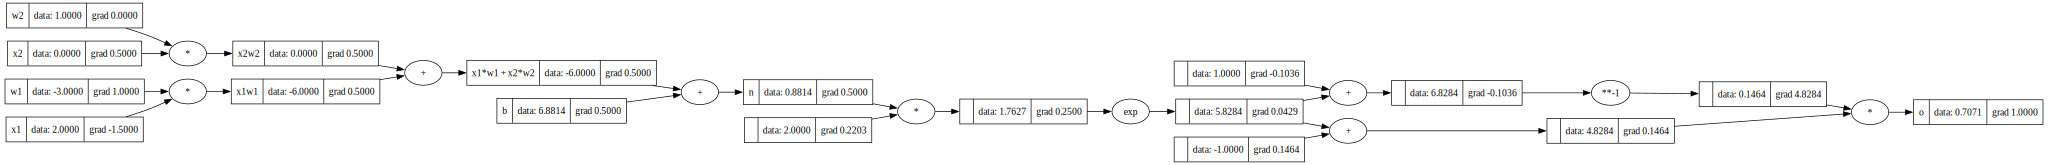

In [33]:
# We want to define a net with two inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Define the weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias: the bias determine how "trigger happy" each neuron is. in other words its "synaptic strength"
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
#---
e = (2 * n).exp()
o = (e - 1) / (e + 1) 
#---
o.label = 'o'
o.backward()
draw_dot(o)

## Chapter 7: Implementing the same thing in PyTorch

In [34]:
import torch 

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True 
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True 
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True 
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True 
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True 

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


The big deal in PyTorch is that because we are dealing with these Tensors rather than floating point numbers (or Value objects) then we can parallelize the computations and it is far more efficient. 

## Chapter 8: Building out multi-layer perceptron in micrograd

In [213]:
import random

class Neuron: 
    def __init__(self, nin): 
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    # "Call" or "forward" the neuron (calculate its value)
    def __call__(self, x): 
        # w * x + b
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # Zip creates an iterator over the tuples
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer: 
    def __init__(self, nin, nout): 
        # nout is the number of outputs. This = the number of neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]

    # Compute the forward pass of this layer
    # This means computing the individual forward passes of each neuron within 
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self): 
        params = []
        for neuron in self.neurons: 
            ps = neuron.parameters()
            params.extend(ps)
        return params


class MLP: # Multilayer perceptron 
    def __init__(self, nin, nouts): 
        # nouts is a list of nout. The size of each layer in the MLP
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    # Call each layer
    def __call__(self, x): 
        for layer in self.layers: 
            x = layer(x)
        return x

    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]
        
n = MLP(3, [4, 4, 1])
n(x)

len(n.parameters()) # The number of total parameters in the model

41

In [214]:
# Creating a simple dataset
# Four 3-dimensional inputs into the net 
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# When it is fed xs[i], the output is ys[i] OBSERVED
# This is a very simple binary classifier


### Run the following over and over to minimize loss

This is simply gradient descent. Forward pass, backward pass, update

In [274]:
# Forward pass
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9651614640526309),
 Value(data=-0.9837708027431882),
 Value(data=-0.9957745846520962),
 Value(data=0.9405784970390451)]

In [279]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)))
loss

Value(data=0.005025879579557713)

In [276]:
loss.backward() # Backprop calculates the gradient wrt to each parameter.

In [277]:
for p in n.parameters(): 
    # Want to iterate over all of the parameters and slightly bump each one in the opposite direction as the gradient
    p.data += -0.01 * p.grad

In [278]:
# This is the setting of the weights and biases that make this net have low loss on the data 
n.parameters() 

[Value(data=-0.546726697330763),
 Value(data=0.440231011662121),
 Value(data=-0.06603395501649553),
 Value(data=-0.37133150053958036),
 Value(data=0.12854250905398734),
 Value(data=-0.6175370377915743),
 Value(data=1.1313510815440608),
 Value(data=0.7301480510860363),
 Value(data=-0.24626392761642307),
 Value(data=-0.5629180622354832),
 Value(data=0.8818840853611386),
 Value(data=1.0478017312401722),
 Value(data=-0.5177801309399193),
 Value(data=0.9625784319255715),
 Value(data=-0.08687161237605143),
 Value(data=0.7483819470356747),
 Value(data=0.2665766677147213),
 Value(data=0.8799494833531976),
 Value(data=0.3583975658860267),
 Value(data=-0.5495465087203784),
 Value(data=0.737925776273241),
 Value(data=-0.21034245189718875),
 Value(data=-0.5934744140903004),
 Value(data=-0.001532905047354774),
 Value(data=1.6278548065079461),
 Value(data=0.9277589998144832),
 Value(data=-0.10852999226318237),
 Value(data=1.4766078976606913),
 Value(data=1.5597675292929254),
 Value(data=-0.790933486

### Now, lets implement an actual training loop

In [300]:
# Same example as above (but reinitialized with different weights)
n = MLP(3, [4, 4, 1])
# Creating a simple dataset
# Four 3-dimensional inputs into the net 
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
STEP_SIZE = 0.1

In [315]:
for k in range(20): 
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    print(k, loss.data)
    
    # Backward pass
    
    # Need to prevent a common bug here. Recall that when we call backward(), we are summing 
    # the local gradients across all of the neurons that are connected with a particular neuron.
    # Before every backward pass, we need to "zero out" the gradients so that we dont continue
    # to add to the gradients and are instead recalculating the gradients each time. 
    # If we dont do this, the grads accumulate and we effectively get a massive step size.
    for p in n.parameters(): 
        p.grad = 0.0
    loss.backward()
    
    # Update
    for p in n.parameters(): 
        p.data += -STEP_SIZE * p.grad

0 0.0009028397964756976
1 0.0008993947799507174
2 0.0008959752323610421
3 0.0008925808752126055
4 0.0008892114340355236
5 0.0008858666383118987
6 0.000882546221405185
7 0.0008792499204909874
8 0.0008759774764894265
9 0.0008727286339988634
10 0.0008695031412310685
11 0.0008663007499477603
12 0.0008631212153983973
13 0.000859964296259357
14 0.0008568297545743784
15 0.0008537173556961758
16 0.0008506268682292857
17 0.000847558063974169
18 0.0008445107178723058
19 0.0008414846079525904


In [302]:
ypred

[Value(data=0.9511148996180567),
 Value(data=-0.984967469848062),
 Value(data=-0.9431466751032809),
 Value(data=0.9491138191598083)]